### Model Selection
In order to select the best model for our data, I am going to look at scores for a variety of scikit-learn models and compare them using visual tools from Yellowbrick. 

### Imports

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

### About the Data

I am using Home Mortgage Disclosure Act (HMDA) data for one year 2013,sample of 25,000 observations. https://www.consumerfinance.gov/data-research/hmda/explore 

Let's load the data:

In [2]:
dataset = pd.read_csv("/Users/tamananaheeme/Desktop/fixtures/hmda2013sample.csv")
dataset.head(5)

,Unnamed: 0,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,...,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,agency_name,agency_abbr,action_taken_name
0,0,117.730003,NaN,5180,63.189999,992,1215,79,61300,56,...,Male,NaN,NaN,NaN,NaN,White,Hispanic or Latino,National Credit Union Administration,NCUA,Loan originated
1,1,84.919998,NaN,4873,23.070000,1152,1882,128,54900,75,...,Female,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated
2,2,42.509998,NaN,1715,58.480000,346,784,43,68700,38,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Application denied by financial institution
3,3,106.650002,NaN,4071,15.920000,1180,1472,100,67800,65,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Application denied by financial institution
4,4,88.489998,NaN,3001,16.790001,503,330,103,77800,151,...,Female,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Consumer Financial Protection Bureau,CFPB,Application approved but not accepted


In [3]:
dataset['action_taken'] = dataset.action_taken_name.apply(lambda x: 1 if x in ['Loan purchased by the institution', 'Loan originated'] else 0)
pd.crosstab(dataset['action_taken_name'],dataset['action_taken'], margins=True)

action_taken,0,1,All
action_taken_name,,,
Application approved but not accepted,1038,0,1038
Application denied by financial institution,3819,0,3819
Application withdrawn by applicant,2220,0,2220
File closed for incompleteness,753,0,753
Loan originated,0,14142,14142
Loan purchased by the institution,0,3028,3028
All,7830,17170,25000


In [4]:
print(dataset.describe())

         Unnamed: 0  tract_to_msamd_income  rate_spread    population  \
count  25000.000000           25000.000000   670.000000  25000.000000   
mean   12499.500000             117.659708     2.532134   5330.473960   
std     7217.022701              42.180985     1.541076   2393.740737   
min        0.000000              13.040000     1.500000    158.000000   
25%     6249.750000              90.489998     1.660000   3803.000000   
50%    12499.500000             110.830002     1.920000   4972.000000   
75%    18749.250000             138.389999     2.792500   6425.250000   
max    24999.000000             405.700012    13.500000  33201.000000   

       minority_population  number_of_owner_occupied_units  \
count         25000.000000                    25000.000000   
mean             30.654104                     1409.926200   
std              25.230882                      694.167618   
min               1.000000                        6.000000   
25%              10.940000      

In [5]:
features = ['tract_to_msamd_income', 
    'population', 
    'minority_population', 
    'number_of_owner_occupied_units', 
    'number_of_1_to_4_family_units', 
    'loan_amount_000s', 
    'hud_median_family_income', 
    'applicant_income_000s']

target = ['action_taken']


In [6]:
# Extract our X and y data
X = dataset[features]
y = dataset[target]

print(X.shape, y.shape)

(25000, 8) (25000, 1)


In [7]:
# add line of code to fill in missing values
X.fillna(X.mean(), inplace=True)

In [8]:
X.describe()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000
mean,117.659708,5330.473960,30.654104,1409.926200,1821.22132,216.371720,70200.892000,113.075120
std,42.180985,2393.740737,25.230882,694.167618,845.79343,210.610144,16193.235984,166.405326
min,13.040000,158.000000,1.000000,6.000000,1.00000,1.000000,16400.000000,1.000000
25%,90.489998,3803.000000,10.940000,929.750000,1275.75000,101.000000,60000.000000,52.000000
50%,110.830002,4972.000000,22.129999,1330.000000,1717.00000,169.000000,66000.000000,82.000000
75%,138.389999,6425.250000,43.320000,1780.000000,2261.00000,277.000000,77800.000000,129.000000
max,405.700012,33201.000000,99.870003,6886.000000,9464.00000,10000.000000,112200.000000,8814.000000


### Modeling and Evaluation


In [9]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 

    model = Pipeline([
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [10]:
# Try them all!

models = [
    GaussianNB(), BernoulliNB(), MultinomialNB(),
    LogisticRegression(solver='lbfgs', max_iter=4000), LogisticRegressionCV(cv=3, max_iter=4000), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X, y, model)

GaussianNB: 0.7935713744219545
BernoulliNB: 0.8143229784206782
MultinomialNB: 0.5886471787899388
LogisticRegression: 0.8140529241294124
LogisticRegressionCV: 0.8140705904707616
BaggingClassifier: 0.9903065234477338
ExtraTreesClassifier: 0.9996212893640574
RandomForestClassifier: 0.9996214658008911


### Visual Model Evaluation


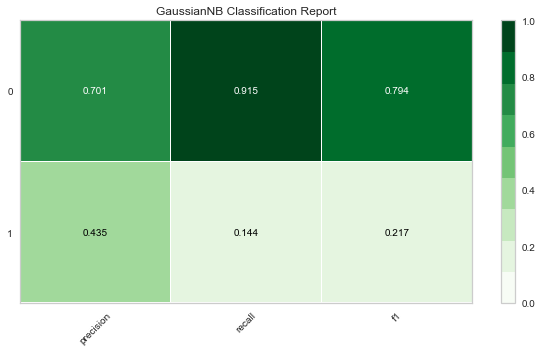

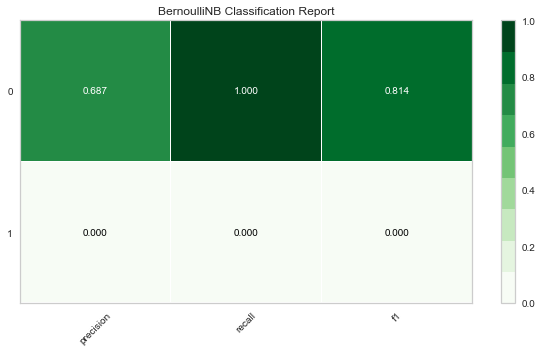

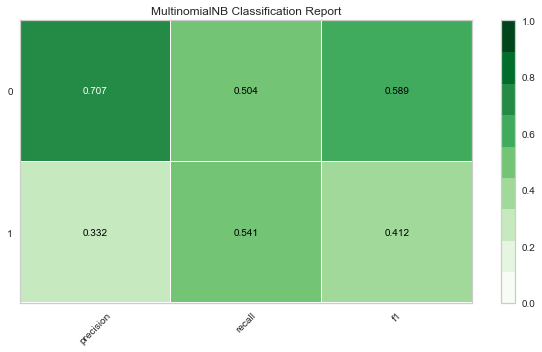

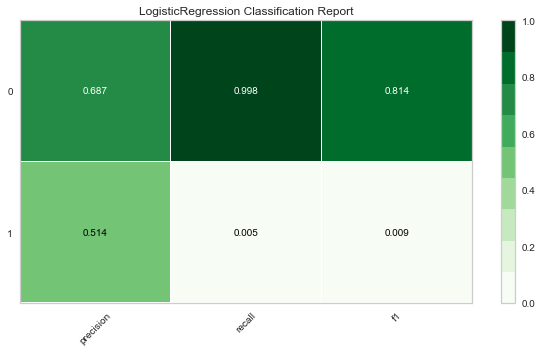

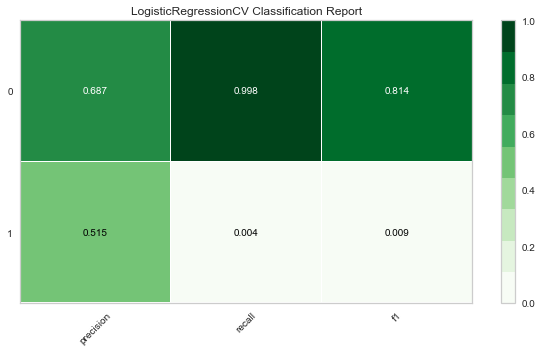

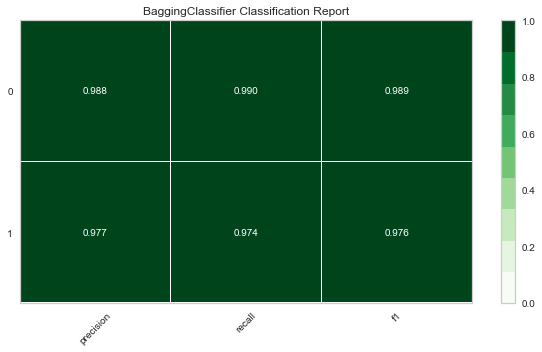

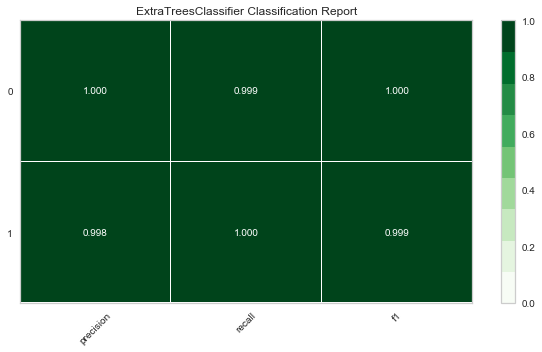

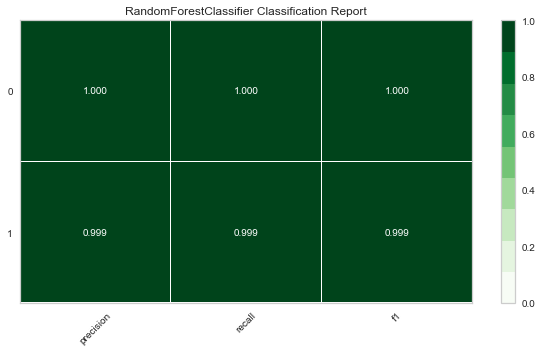

In [11]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    model = Pipeline([
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=[1,0], 
        cmap="greens", size=(600, 360)
    )
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof()  

for model in models:
    visualize_model(X, y, model)